In [ ]:
# !pip install --upgrade scikit-learn

### 1. Imports des modules

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from statistics import mean 

from datetime import datetime
import ast

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_validate

#CLASSIFIEURS
from sklearn import discriminant_analysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

#CLUSTERING
from sklearn.cluster import KMeans
import scipy.cluster.hierarchy as shc
from sklearn.cluster import AgglomerativeClustering

from tqdm import tqdm_notebook as tqdm 


### 2. Lecture des données

In [2]:
parse_dates = ['DATE']
glasses_df = pd.read_csv("./donnees/glasses.csv", parse_dates= parse_dates)
parse_dates = ['timestamp']
smartwatch_df = pd.read_csv("./donnees/smartwatch.csv", parse_dates= parse_dates)
smartphone_df = pd.read_csv("./donnees/smartphone.csv", parse_dates= parse_dates)
parse_dates = ['to', 'from']
report_df = pd.read_csv("./donnees/report.csv", parse_dates= parse_dates)

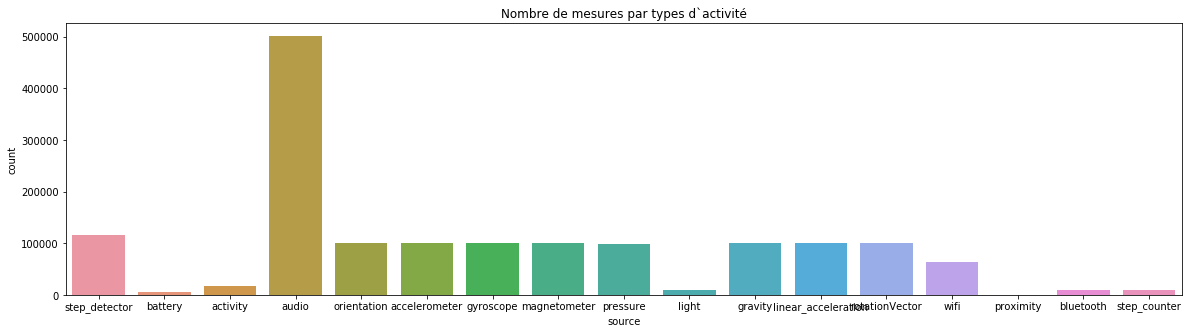

In [3]:
fig, ax = plt.subplots(figsize=(20,5))
ax = sns.countplot(x="source", data=smartphone_df).set_title('Nombre de mesures par types d`activité')

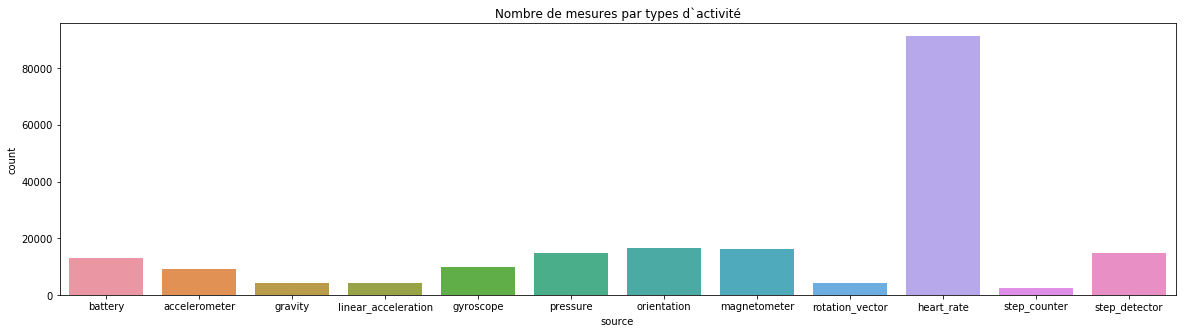

In [4]:
fig, ax = plt.subplots(figsize=(20,5))
ax = sns.countplot(x="source", data=smartwatch_df).set_title('Nombre de mesures par types d`activité')

### 3. Preparation des donnees Smartwatch

In [5]:
data = {}

data['heart_rate'] = [None] * len(smartwatch_df)
# data['steps'] = [None] * len(smartwatch_df)
# data['accelerometer'] = [None] * len(smartwatch_df)



for index, row in tqdm(smartwatch_df.iterrows(), total=len(smartwatch_df)):
    
    
    values = [ float(x) for x in ast.literal_eval(row['values']) ]

    if row['source'] == 'heart_rate':
        data['heart_rate'][index] = values[0]

#     if row['source'] == 'step_detector':
#         data['steps'][index] = values[0]
    
#     if row['source'] == 'accelerometer':
#         data['accelerometer'][index] = (sum([x**2 for x in values]))**0.5

smartwatch_df["heart_rate"] = data['heart_rate']
# smartwatch_df["steps"] = data['steps']
# smartwatch_df["accelerometer"] = data['accelerometer']


resampling_functions = {
    'heart_rate': np.mean,
#     'steps': np.sum,
#     'accelerometer': np.mean
}

smartwatch_df = smartwatch_df[ 
                                smartwatch_df['heart_rate'].notnull()  
#                                 smartwatch_df['steps'].notnull() |
#                                 smartwatch_df['accelerometer'].notnull()
    
                             ]

smartwatch_df = smartwatch_df.set_index('timestamp')
smartwatch_df = smartwatch_df['heart_rate']
smartwatch_df = smartwatch_df.resample('min').agg(resampling_functions)
# smartwatch_df['steps'].fillna(0.0, inplace=True)
smartwatch_df = smartwatch_df.dropna()
smartwatch_df.head()

HBox(children=(IntProgress(value=0, max=200471), HTML(value='')))

            timestamp          
heart_rate  2017-06-29 07:46:00    129.568182
            2017-06-29 07:47:00    111.095238
            2017-06-29 07:48:00     75.076923
            2017-06-29 07:49:00     68.076923
            2017-06-29 07:50:00     64.666667
Name: heart_rate, dtype: float64

In [ ]:
# smartwatch_df.loc[smartwatch_df['steps']<=3, 'steps'] = 0
# smartwatch_df.loc[smartwatch_df['steps']>3, 'steps'] = 1
# smartwatch_df.head()

### 3. Preparation des donnees Smartphone

In [6]:
data = {}

# data['activity'] = [None] * len(smartphone_df)

# data['light'] = [None] * len(smartphone_df)
data['audio'] = [None] * len(smartphone_df)
data['steps'] = [None] * len(smartphone_df)
data['wifi'] = [None] * len(smartphone_df)
# data['bluetooth'] = [None] * len(smartphone_df)
data['accelerometer'] = [None] * len(smartphone_df)


for index, row in tqdm(smartphone_df.iterrows(), total=len(smartphone_df)):
    
    if row['source'] != 'activity':
        values = [ float(x) for x in ast.literal_eval(row['values']) ]
#     else:
#         data['activity'][index] = values[0]
    
#         if row['source'] == 'light':
#             data['light'][index] = values[0]

        if row['source'] == 'audio':
            data['audio'][index] = mean(values)

        if row['source'] == 'step_detector':
            data['steps'][index] = values[0]

        if row['source'] == 'accelerometer':
            data['accelerometer'][index] = (sum([x**2 for x in values]))**0.5

        if row['source'] == 'wifi':
            data['wifi'][index] = len(values)

#         if row['source'] == 'bluetooth':
#             data['bluetooth'][index] = len(values)
        

# smartwatch_df["activity"] = data['activity']
# smartphone_df["light"] = data['light']
smartphone_df["audio"] = data['audio']
smartphone_df["wifi"] = data['wifi']
# smartphone_df["bluetooth"] = data['bluetooth']
smartphone_df["steps"] = data['steps']
smartphone_df["accelerometer"] = data['accelerometer']


resampling_functions = {
#     'light': np.mean,
    'audio': np.mean,
    'wifi': np.mean,
#     'bluetooth': np.mean,
    'steps': np.sum,
    'accelerometer': np.mean
}

smartphone_df = smartphone_df[ 
#                     smartphone_df['light'].notnull() | 
                    smartphone_df['audio'].notnull() | 
                    smartphone_df['wifi'].notnull() | 
#                     smartphone_df['bluetooth'].notnull() | 
                    smartphone_df['steps'].notnull() |
                    smartphone_df['accelerometer'].notnull()
                             ]

smartphone_df = smartphone_df.set_index('timestamp')
smartphone_df = smartphone_df[['audio','wifi', 'steps', 'accelerometer']]
smartphone_df = smartphone_df.resample('min').agg(resampling_functions)
smartphone_df['steps'].fillna(0.0, inplace=True)
smartphone_df = smartphone_df.dropna()
smartphone_df.head()

HBox(children=(IntProgress(value=0, max=1528218), HTML(value='')))

,audio,wifi,steps,accelerometer
timestamp,,,,
2017-06-29 07:45:00,7843.096284,3.250000,6.0,9.648525
2017-06-29 07:46:00,9393.916199,2.833333,0.0,9.535087
2017-06-29 07:47:00,11556.857947,3.666667,23.0,9.262378
2017-06-29 07:48:00,10962.091658,3.500000,11.0,9.459278
2017-06-29 07:49:00,9936.258735,4.500000,5.0,9.496311


### 3. Jointure des datasets

In [7]:
df = smartphone_df.join(smartwatch_df, lsuffix='_sp', rsuffix='_sw')
df = df.reset_index(level=0)
df = df.drop('level_0', axis = 1)
df.describe()

,audio,wifi,steps,accelerometer,heart_rate
count,2941.000000,2941.000000,2941.000000,2941.000000,2941.000000
mean,11054.503442,9.169480,20.901054,10.211509,70.346160
std,1879.503866,15.076354,36.824673,1.449701,13.578696
min,1827.792060,0.000000,0.000000,6.795452,47.666667
25%,9769.336971,3.000000,0.000000,9.674455,62.285714
50%,10602.857125,4.000000,1.000000,9.903864,67.532738
75%,11716.650800,5.833333,26.000000,10.099466,74.500000
max,18595.348573,123.250000,170.000000,29.229536,166.800000


In [8]:
report_df.head()

,index,activity_type,duration,from,to,comment
0,0,Video games,01:43,2017-07-01 21:34:00,2017-07-01 23:17:00,NaN
1,1,In computer,00:03,2017-07-01 21:29:00,2017-07-01 21:32:00,NaN
2,2,At home,13:35,2017-07-01 21:13:00,2017-07-02 10:49:00,NaN
3,3,In computer,00:05,2017-07-01 21:08:00,2017-07-01 21:13:00,NaN
4,4,Eat,00:18,2017-07-01 20:49:00,2017-07-01 21:07:00,NaN


In [9]:
data = {}
data['activity_index'] = [None] * len(df)
data['activity_type'] = [None] * len(df)

i=0
for index, row in tqdm(df.iterrows(), total=len(df)):
    for report_index, report_row in report_df.iterrows():
        if (index >= report_row['from']) & (index < report_row['to']):
#             data['activity_index'][i] = int(report_row['index'])
            data['activity_type'][i] = report_row['activity_type']
    i=i+1

df["activity_index"] = data['activity_index']
df["activity_type"] = data['activity_type']
df = df.dropna()
df.head()

HBox(children=(IntProgress(value=0, max=2941), HTML(value='')))

,audio,wifi,steps,accelerometer,heart_rate,activity_index,activity_type
timestamp,,,,,,,
2017-06-29 09:57:00,12883.949970,47.125000,91.0,12.654205,76.083333,12.0,Eat
2017-06-29 09:58:00,12258.789152,56.750000,53.0,10.117409,83.500000,12.0,Eat
2017-06-29 10:01:00,12155.157763,60.000000,50.0,9.982670,58.784810,12.0,Eat
2017-06-29 10:02:00,13177.428694,65.666667,107.0,10.720635,71.727273,12.0,Eat
2017-06-29 10:03:00,12905.517089,65.500000,91.0,10.717644,91.750000,12.0,Eat


### 3. Exploration des donnees

In [10]:
df.describe()

,audio,wifi,steps,accelerometer,heart_rate,activity_index
count,1486.000000,1486.000000,1486.000000,1486.000000,1486.000000,1486.000000
mean,11186.460741,9.215078,20.471063,10.269537,70.488197,6.926649
std,2008.689603,15.836743,37.460626,1.501122,15.445777,4.271352
min,1827.792060,0.000000,0.000000,8.523582,49.250000,0.000000
25%,9770.442541,3.000000,0.000000,9.700441,62.193382,4.000000
50%,10655.715156,4.000000,1.000000,9.968008,67.383484,7.000000
75%,11968.765699,5.833333,25.000000,10.132207,73.909091,10.000000
max,18595.348573,123.250000,170.000000,25.912000,166.800000,20.000000


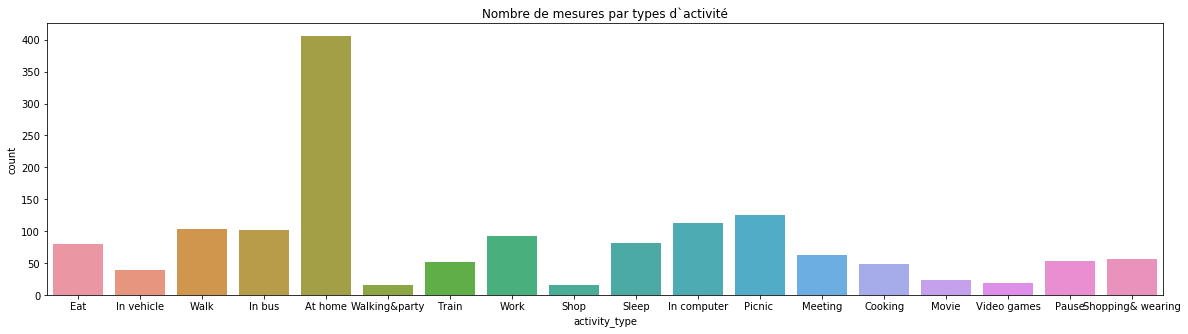

In [11]:
fig, ax = plt.subplots(figsize=(20,5))
ax = sns.countplot(x="activity_type", data=df).set_title('Nombre de mesures par types d`activité')

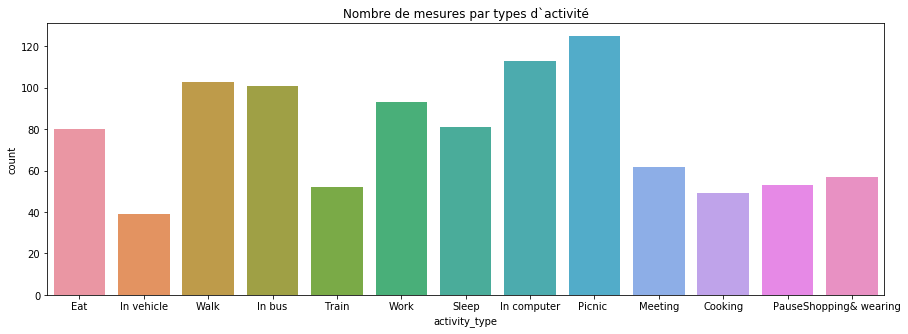

In [12]:
df = df.drop(df.index[df['activity_type'] == 'At home'], axis = 0)
df = df.drop(df.index[df['activity_type'] == 'Walking&party'], axis = 0)
for activity_type in df['activity_type'].unique():
    if len(df[df['activity_type'] == activity_type])<30:
        df = df.drop(df.index[df['activity_type'] == activity_type], axis = 0)

fig, ax = plt.subplots(figsize=(15,5))
ax = sns.countplot(x="activity_type", data=df).set_title('Nombre de mesures par types d`activité')

In [ ]:
list(df.columns)

In [13]:
variables = [
    'audio',
    'wifi',
    'steps',
    'accelerometer',
    'heart_rate',
]

# Centrage reduction des donnees quantitatives
normal_scaler = preprocessing.StandardScaler()
normal_scaler_fit = normal_scaler.fit(df[variables])
normal = normal_scaler_fit.transform(df[variables])

# X et Y: entrees et sorties du modele

X = pd.DataFrame(normal, columns=variables)

y = df['activity_type']

df_normal = pd.DataFrame(normal, columns=variables)
df_normal['activity_type'] = df['activity_type'].tolist()

In [14]:
df_normal.head()

,audio,wifi,steps,accelerometer,heart_rate,activity_type
0,0.793907,2.073886,2.185767,2.398010,0.677920,Eat
1,0.473250,2.620555,1.043126,-0.028907,1.410497,Eat
2,0.420095,2.805145,0.952917,-0.157810,-1.030732,Eat
3,0.944437,3.126994,2.666880,0.548190,0.247653,Eat
4,0.804969,3.117528,2.185767,0.545329,2.225386,Eat


In [15]:
df[variables].describe()

,audio,wifi,steps,accelerometer,heart_rate
count,1008.000000,1008.000000,1008.000000,1008.000000,1008.000000
mean,11336.128991,10.610904,18.309524,10.147625,69.220020
std,1950.593885,17.615350,33.272780,1.045794,10.129101
min,1827.792060,0.000000,0.000000,8.523582,49.250000
25%,9874.640851,3.166667,0.000000,9.689484,62.245876
50%,10739.003508,4.000000,0.000000,9.934155,67.571429
75%,12350.126957,8.083333,22.000000,10.129875,73.942308
max,18595.348573,123.250000,147.000000,19.418213,111.000000


In [16]:
df_normal.describe()

,audio,wifi,steps,accelerometer,heart_rate
count,1.008000e+03,1.008000e+03,1.008000e+03,1.008000e+03,1.008000e+03
mean,7.864080e-16,4.901282e-18,-4.515788e-17,-2.137510e-15,2.290386e-16
std,1.000496e+00,1.000496e+00,1.000496e+00,1.000496e+00,1.000496e+00
min,-4.877005e+00,-6.026659e-01,-5.505585e-01,-1.553699e+00,-1.972528e+00
25%,-7.496248e-01,-4.228092e-01,-5.505585e-01,-4.382972e-01,-6.888673e-01
50%,-3.062769e-01,-3.754785e-01,-5.505585e-01,-2.042240e-01,-1.628387e-01
75%,5.200987e-01,-1.435581e-01,1.109708e-01,-1.698078e-02,4.664414e-01
max,3.723391e+00,6.397546e+00,3.869660e+00,8.869040e+00,4.126795e+00


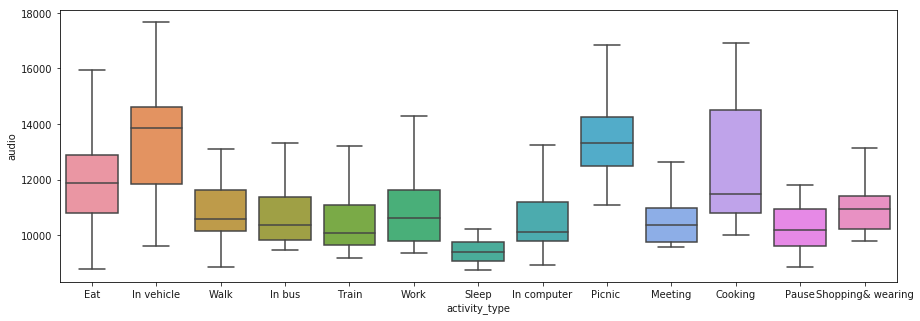

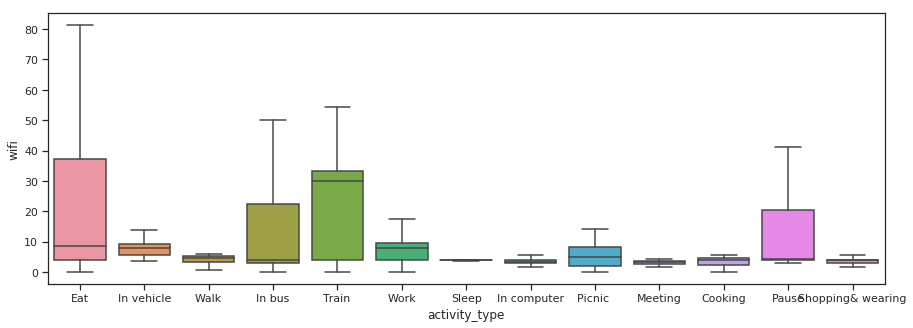

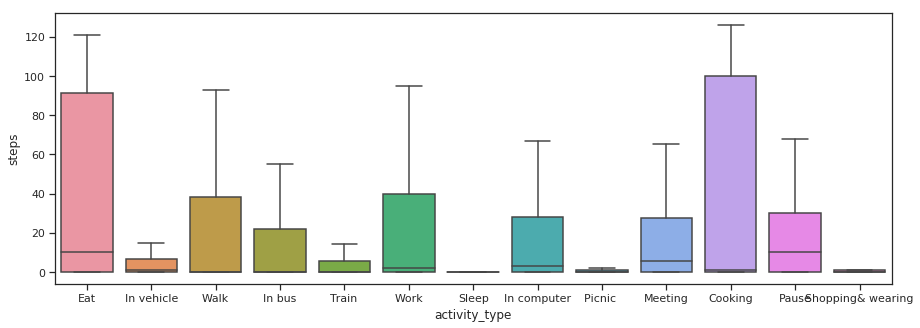

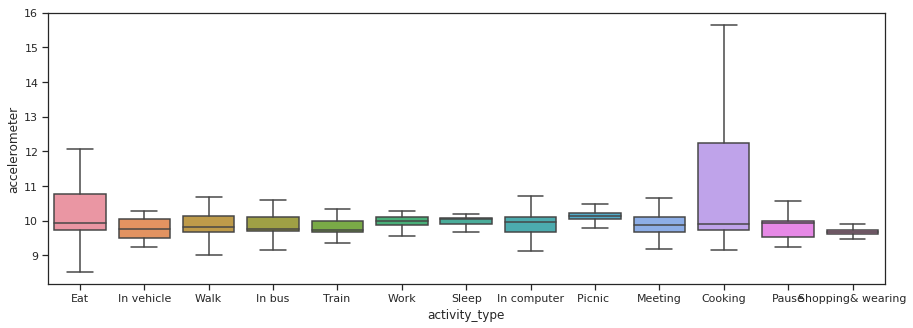

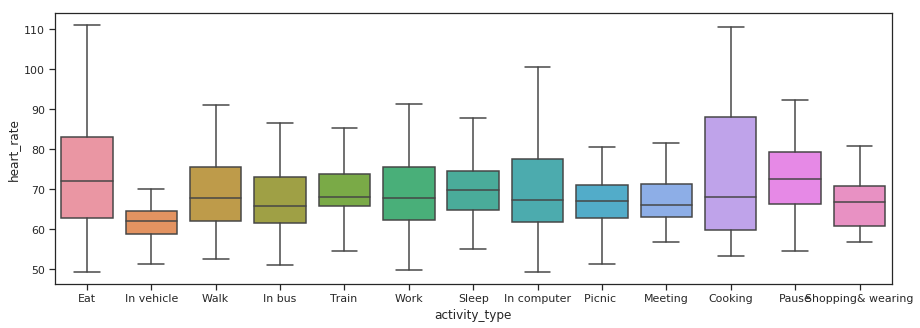

In [17]:
for variable in variables:
    fig, ax = plt.subplots(figsize=(15,5))
    sns.set(style="ticks", color_codes=True)
    sns.boxplot(x="activity_type", y=variable, data=df, showfliers=False)

### 4.  Corrélations

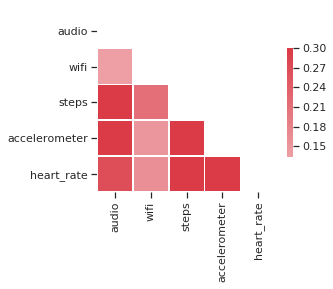

In [18]:
# Matrice de correlation
corr = X.corr()

# Pour n'afficher que la partie inferieure de la matrice
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Afficher la heatmap
f, ax = plt.subplots(figsize=(4, 4))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

### 4.  Analyse par Composantes Principales

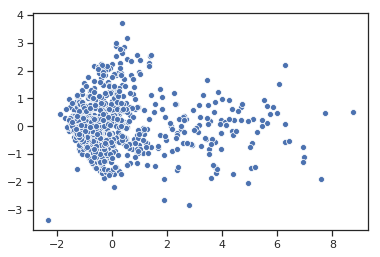

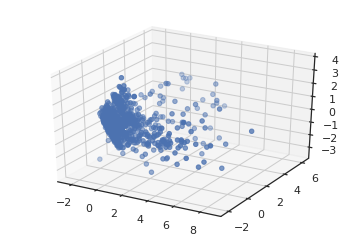

 
Explained variances:
[0.5034019801190776, 0.1860789463108766, 0.1474059459410984, 0.10530835183517316, 0.057804775793774285]
 
Sum of explained variances: 1.0
 


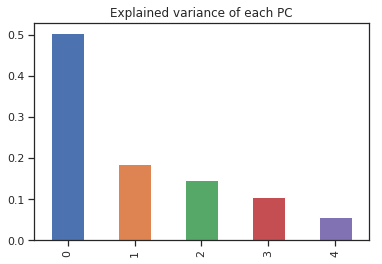

In [24]:
n_components = 5
pca = PCA(n_components = n_components)
X_pca = pca.fit_transform(X)

sns.scatterplot(X_pca[:, 0], X_pca[:, 2])
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_pca[:, 0], X_pca[:, 1],  X_pca[:, 2])
plt.show()

print(' ')
print('Explained variances:')
print(pca.explained_variance_ratio_.tolist())
pd.Series(pca.explained_variance_ratio_.tolist()).plot(kind="bar", title= "Explained variance of each PC")
print(' ')
print('Sum of explained variances: ' + str(sum(pca.explained_variance_ratio_.tolist())))
print(' ')

## 5. Classification non-supervisée

### 5.1. CAH

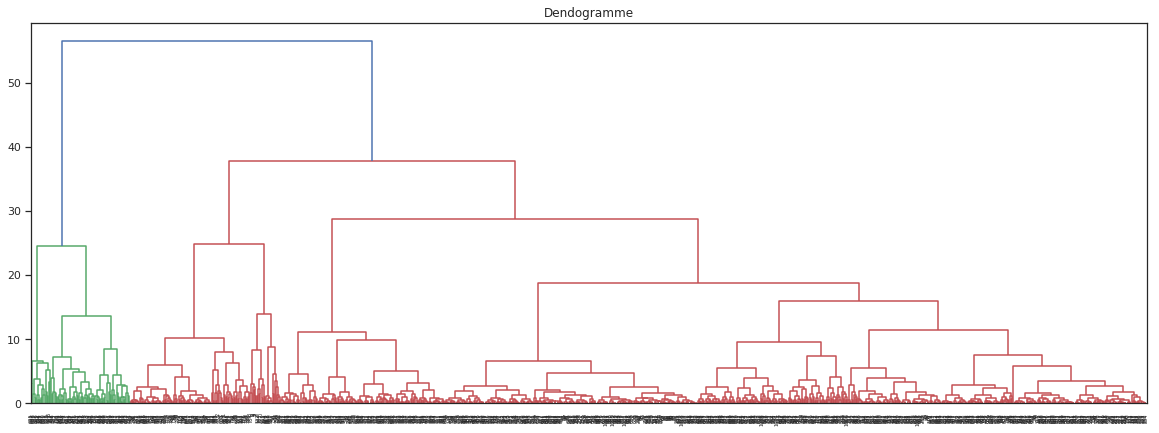

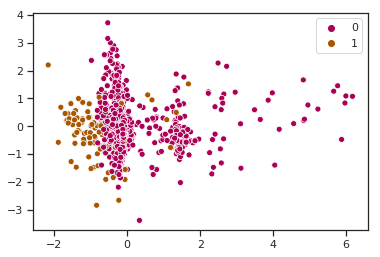

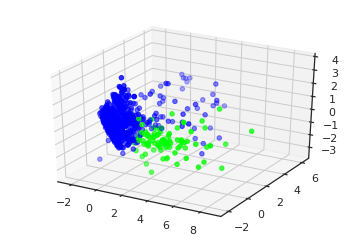

In [25]:
plt.figure(figsize=(20, 7))  
plt.title("Dendogramme")  
dend = shc.dendrogram(shc.linkage(X, method='ward'))    

cluster = AgglomerativeClustering(n_clusters=2, affinity='euclidean', linkage='ward')  
cluster.fit_predict(X) 

plt.show()
sns.scatterplot(X_pca[:, 1], X_pca[:, 2],  hue=cluster.labels_, palette = 'brg')

plt.show()
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_pca[:, 0], X_pca[:, 1],  X_pca[:, 2], c=cluster.labels_, cmap = 'brg') 

### 5.2. K-Means

#### 5.2.1. Sans PCA

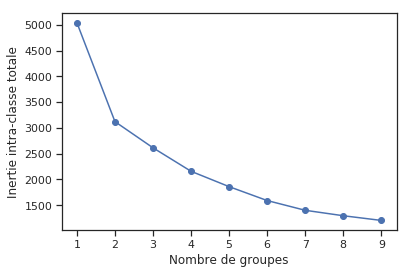

Centres des classes:
      audio      wifi     steps  accelerometer  heart_rate
0  1.406039  0.787608  2.435737       1.872692    1.657070
1 -0.181069 -0.101428 -0.313673      -0.241164   -0.213396


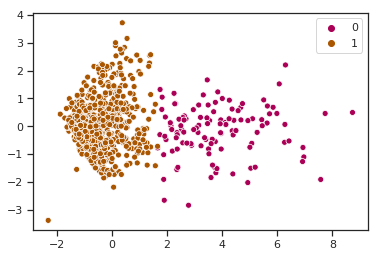

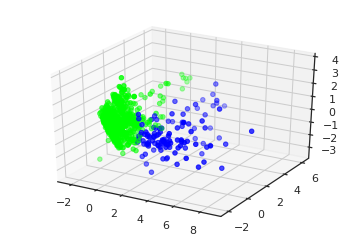

In [27]:
inerties = []
for i in range(1, 10):
    km = KMeans(n_clusters=i, 
                random_state=0)
    km.fit(X)
    inerties.append(km.inertia_)

plt.plot(range(1, 10), inerties, marker='o')
plt.xlabel('Nombre de groupes')
plt.ylabel('Inertie intra-classe totale')
plt.show()

km_n_clusters_ = 2
kmeans = KMeans(n_clusters=km_n_clusters_, random_state=0).fit(X)
km_labels = kmeans.labels_
km_n_clusters_ = len(np.unique(km_labels))
centers_km = pd.DataFrame(kmeans.cluster_centers_, columns=variables)

print('Centres des classes:')
print(centers_km)

plt.show()
sns.scatterplot(X_pca[:, 0], X_pca[:, 2],  hue=km_labels, palette = 'brg')

plt.show()
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_pca[:, 0], X_pca[:, 1],  X_pca[:, 2], c=km_labels, cmap = 'brg') 

#### 5.2.2. Avec PCA

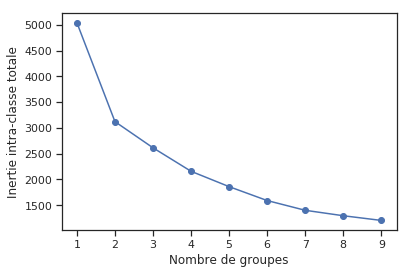

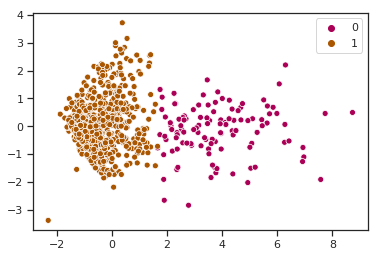

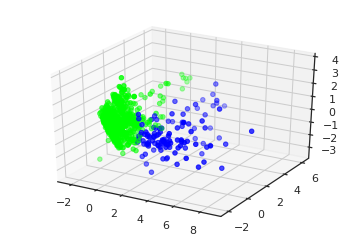

In [29]:
inerties = []
for i in range(1, 10):
    km = KMeans(n_clusters=i, 
                random_state=0)
    km.fit(X_pca)
    inerties.append(km.inertia_)

plt.plot(range(1, 10), inerties, marker='o')
plt.xlabel('Nombre de groupes')
plt.ylabel('Inertie intra-classe totale')
plt.show()

km_n_clusters_ = 2
kmeans = KMeans(n_clusters=km_n_clusters_, random_state=0).fit(X_pca)
km_labels = kmeans.labels_
km_n_clusters_ = len(np.unique(km_labels))
# centers_km = pd.DataFrame(kmeans.cluster_centers_, columns=variables)

# print('Centres des classes:')
# print(centers_km)

plt.show()
sns.scatterplot(X_pca[:, 0], X_pca[:, 2],  hue=km_labels, palette = 'brg')

plt.show()
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_pca[:, 0], X_pca[:, 1],  X_pca[:, 2], c=km_labels, cmap = 'brg') 

Index de Rand pour comparer les groupements non supervises

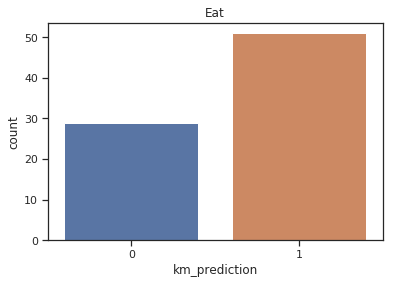

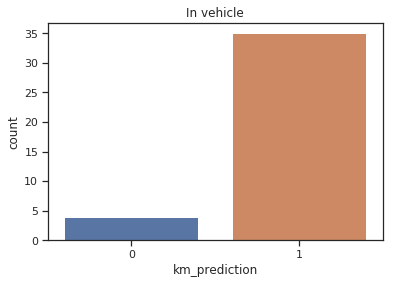

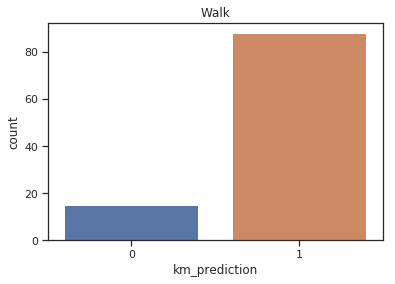

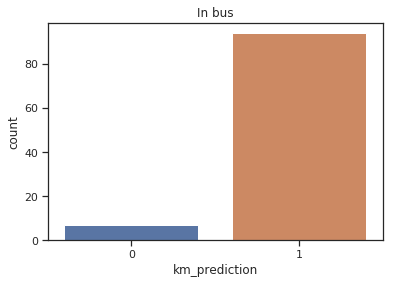

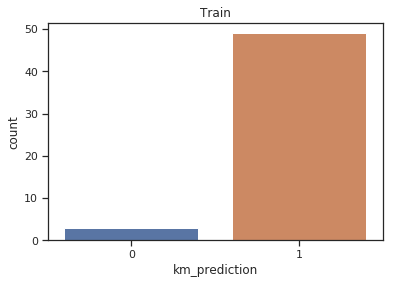

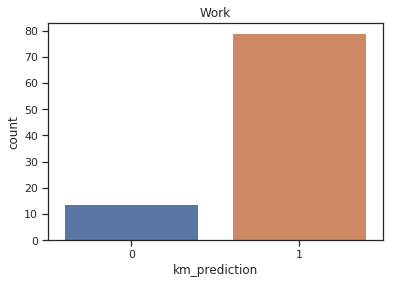

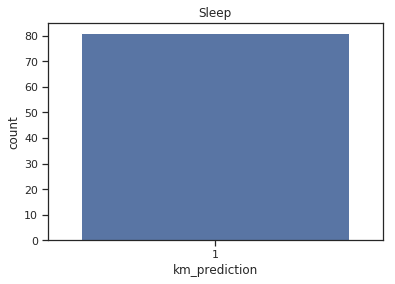

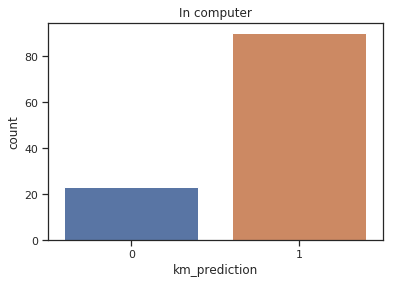

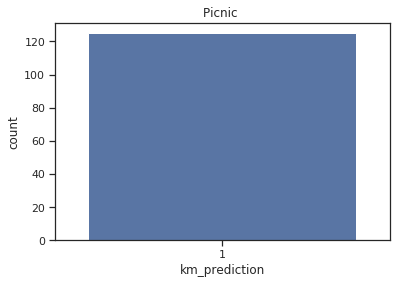

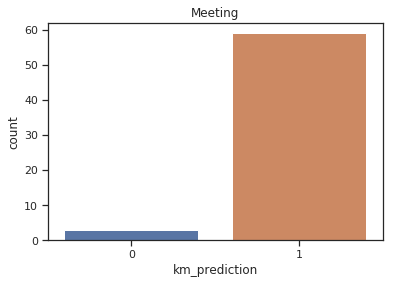

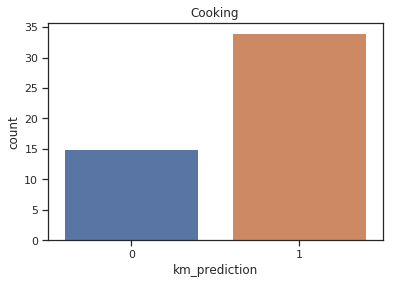

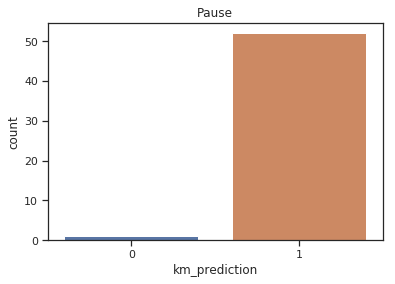

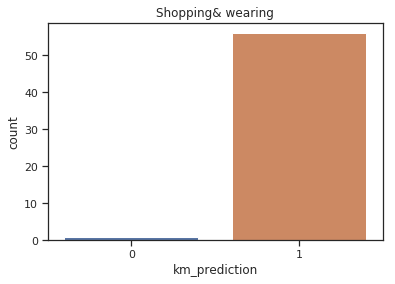

In [30]:
y = pd.DataFrame(y)
y['km_prediction']=km_labels
for activity_type in y['activity_type'].unique():
    data = y[y['activity_type'] == activity_type]
    plt.show()
    sns.countplot(x="km_prediction", data=data).set_title(activity_type)

### 5. Classification

#### Sans l'ACP:

In [44]:
activites = ['Eat']
labels = []
for activity_type in list(y['activity_type']):
    if activity_type in activites:
        labels.append(1)
    else:
        labels.append(0)

# labels = y['activity_type']

In [49]:
# len(labels.unique())

In [46]:
X_train, X_test, y_train, y_test = train_test_split(X, labels, test_size=0.3, random_state=101)

In [47]:
names = [
    "Nearest Neighbors",
    "Decision Tree", 
]

classifiers = [
    KNeighborsClassifier(1),
    DecisionTreeClassifier(max_depth=5),
    ]

for name, clf in zip(names, classifiers):
    
    print("\n")
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    score = clf.score(X_test, y_test)
    print(name + ' score: ' + str(round(score, 2)))
    scores = cross_validate(clf, X, labels, cv=3, return_train_score=True)['test_score']
    print(name + ' cross-validated scores: ')
    print(scores)
    print("\n")
    



Nearest Neighbors score: 0.9
Nearest Neighbors cross-validated scores: 
[0.82789318 0.87797619 0.84477612]




Decision Tree score: 0.92
Decision Tree cross-validated scores: 
[0.86350148 0.89285714 0.86567164]




#### Avec l'ACP:

In [48]:
X_train, X_test, y_train, y_test = train_test_split(X_pca, labels, test_size=0.3, random_state=101)

for name, clf in zip(names, classifiers):
    
    print("\n")
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    score = clf.score(X_test, y_test)
    print(name + ' score: ' + str(round(score, 2)))
    scores = cross_validate(clf, X, labels, cv=3, return_train_score=True)['test_score']
    print(name + ' cross-validated scores: ')
    print(scores)
    print("\n")
    



Nearest Neighbors score: 0.9
Nearest Neighbors cross-validated scores: 
[0.82789318 0.87797619 0.84477612]




Decision Tree score: 0.93
Decision Tree cross-validated scores: 
[0.86350148 0.89285714 0.86567164]


